In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from itertools import product

import importlib

import compare_rates
importlib.reload(compare_rates)

<module 'compare_rates' from '/Users/kelley/Projects/PhasingFamilies/parameter_estimation/compare_rates.py'>

In [52]:
chroms = [str(i) for i in range(1, 23)]

gens = ['0/0', '0/1', '1/1']
obss = ['0/0', '0/1', '1/1', './.']

# First, check twins

In [53]:
ihart_samples = compare_rates.pull_samples('../split_gen_ihart_identicals', chroms)
spark_exome_samples = compare_rates.pull_samples('../split_gen_spark_exome_EX_identicals', chroms)
spark_samples = compare_rates.pull_samples('../split_gen_spark_identicals', chroms)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data


In [54]:
ihart_error_rates = compare_rates.pull_error_rates(ihart_samples, 'params/ihart_identicals_params.json', gens, obss)
spark_exome_error_rates = compare_rates.pull_error_rates(spark_exome_samples, 'params/spark_exome_EX_identicals_params.json', gens, obss)
spark_error_rates = compare_rates.pull_error_rates(spark_samples, 'params/spark_identicals_params.json', gens, obss)

ihart_error_counts = compare_rates.pull_error_counts(ihart_samples, 'params/ihart_identicals_params.json', gens, obss)
spark_exome_error_counts = compare_rates.pull_error_counts(spark_exome_samples, 'params/spark_exome_EX_identicals_params.json', gens, obss)
spark_error_counts = compare_rates.pull_error_counts(spark_samples, 'params/spark_identicals_params.json', gens, obss)



In [56]:
def pull_twins(twin_file, data_dir, samples):
    twin_pairs = []
    with open(twin_file, 'r') as f:
        for line in f:
            individuals = [x.split('_')[-1] for x in line.strip().split('\t') if 'LCL' not in x]
            individuals = [x for x in individuals if x in samples.sample_ids]
            if len(individuals) == 2:
                twin_pairs.append(tuple(individuals))
                
    # twin1, twin2
    counts = np.zeros((len(twin_pairs), 4, 4), dtype=int)
    
    famkeys = [None for _ in twin_pairs]
    for i, chrom in enumerate(chroms):
        print(chrom, end=' ')

        with open('%s/chr.%s.famgen.counts.txt' % (data_dir, chrom), 'r') as f:
            for line in f:
                pieces = line.strip().split('\t')
                fk, inds = pieces[:2]
                inds = inds.split('.')
                
                for twinpair_index, (twin1, twin2) in enumerate(twin_pairs):
                    if twin1 in inds and twin2 in inds:
                        famkeys[twinpair_index] = fk
                        ind_to_index = dict([(x, i) for i, x in enumerate(inds)])

                        for g, c in zip(product([0, 1, 2, 3], repeat=len(inds)), pieces[2:]):
                            counts[twinpair_index, g[ind_to_index[twin1]], g[ind_to_index[twin2]]] += int(c)
    return twin_pairs, counts

ihart_twins, ihart_twin_counts = pull_twins('../sibpair_similarity/ihart_identicals.txt', '../split_gen_ihart', ihart_samples)
spark_exome_twins, spark_exome_twin_counts = pull_twins('../sibpair_similarity/spark_exome_identicals.txt', '../split_gen_spark_exome_EX', spark_exome_samples)
spark_twins, spark_twin_counts = pull_twins('../sibpair_similarity/spark_identicals.txt', '../split_gen_spark', spark_samples)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [57]:
mismatches = [('0/0', '0/1'), ('0/0', '1/1'), ('0/1', '1/1'),
             ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]

def twin_expected_vs_observed(twins, samples, error_counts, twin_counts, error_rates):
    print(mismatches)
    # first expected
    expected = np.zeros((2*len(twins), len(mismatches)))
    observed = np.zeros((2*len(twins), len(mismatches)))
    famsize = np.zeros((2*len(twins),))
    
    for i, (twin1, twin2) in enumerate(twins):
        twin1_index, twin2_index = samples.sample_ids.index(twin1), samples.sample_ids.index(twin2)
        for j, (obs1, obs2) in enumerate(mismatches):
            
            # expected
            obs1_index, obs2_index = obss.index(obs1), obss.index(obs2)
            # obs1 is correct, obs2 is the error
            if obs1 in gens:
                expected[2*i, j] = error_counts[twin2_index, obs1_index, obs2_index]
                expected[(2*i)+1, j] = error_counts[twin1_index, obs1_index, obs2_index]
            # obs2 is correct, obs1 is the error
            if obs2 in gens:
                expected[2*i, j] += error_counts[twin1_index, obs2_index, obs1_index]
                expected[(2*i)+1, j] += error_counts[twin2_index, obs2_index, obs1_index]
    
            # observed
            observed[2*i, j] = twin_counts[i, obs1_index, obs2_index]
            observed[(2*i)+1, j] = twin_counts[i, obs2_index, obs1_index]
            
        famsize[2*i] = samples.family_sizes[twin1_index]
        famsize[(2*i) + 1] = samples.family_sizes[twin2_index]
        
        assert samples.family_sizes[twin1_index] == samples.family_sizes[twin2_index]
    
    return expected, observed, famsize

ihart_twins_expected, ihart_twins_observed, ihart_twins_famsize = twin_expected_vs_observed(ihart_twins, ihart_samples, ihart_error_counts, ihart_twin_counts, ihart_error_rates)
spark_exome_twins_expected, spark_exome_twins_observed, spark_exome_twins_famsize = twin_expected_vs_observed(spark_exome_twins, spark_exome_samples, spark_exome_error_counts, spark_exome_twin_counts, spark_exome_error_rates)
spark_twins_expected, spark_twins_observed, spark_twins_famsize = twin_expected_vs_observed(spark_twins, spark_samples, spark_error_counts, spark_twin_counts, spark_error_rates)



[('0/0', '0/1'), ('0/0', '1/1'), ('0/1', '1/1'), ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]
[('0/0', '0/1'), ('0/0', '1/1'), ('0/1', '1/1'), ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]
[('0/0', '0/1'), ('0/0', '1/1'), ('0/1', '1/1'), ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


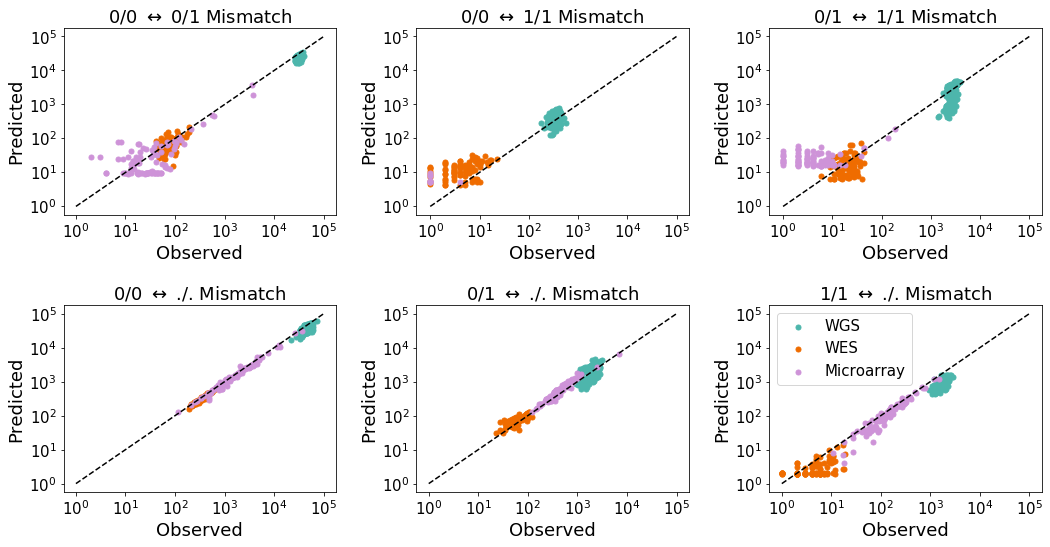

In [58]:
plt.rcParams.update({'font.size': 20})


plt.figure(figsize=(15, 8))
for i, (obs1, obs2) in enumerate(mismatches):
    plt.subplot(2, 3, i+1)
    plt.title(r'%s $\leftrightarrow$ %s Mismatch' % (obs1, obs2), fontsize=18)
    
    plt.scatter(np.log10(ihart_twins_observed[:, i]), 
                np.log10(ihart_twins_expected[:, i]),
                color='#4db6ac', label='WGS', marker='.', s=100)
    
    plt.scatter(np.log10(np.clip(spark_exome_twins_observed[:, i], 1, None)), 
                np.log10(np.clip(spark_exome_twins_expected[:, i], 1, None)),
                color='#ef6c00', label='WES', marker='.', s=100)
    #plt.scatter(np.log10(np.clip(spark_exome_twins_observed[spark_exome_twins_famsize==3, i], 1, None)), 
    #            np.log10(np.clip(spark_exome_twins_expected[spark_exome_twins_famsize==3, i], 1, None)),
    #            color='#ef6c00', marker='x', s=100)
    
    plt.scatter(np.log10(spark_twins_observed[:, i]), 
                np.log10(spark_twins_expected[:, i]),
                color='#ce93d8ff', label='Microarray', marker='.', s=100)
    #plt.scatter(np.log10(np.clip(spark_twins_observed[spark_twins_famsize==3, i], 1, None)), 
    #            np.log10(np.clip(spark_twins_expected[spark_twins_famsize==3, i], 1, None)),
    #            color='#ce93d8ff', label='Microarray', marker='x', s=100)

    plt.plot([0, 5], [0, 5], color='black', linestyle='--')
    plt.xticks(range(6), ['$10^%d$' % d for d in range(6)], fontsize=15)
    plt.yticks(range(6), ['$10^%d$' % d for d in range(56)], fontsize=15)
    plt.xlabel('Observed', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    
    if i==5:
        plt.legend(fontsize=15)
        
        
plt.tight_layout()
plt.savefig('../plots/mismatches.png')
#plt.show()



# Compare LCL/WB

[145, 268, 334, 352, 357, 361, 376, 385, 391, 396, 400, 407] [144, 267, 333, 351, 356, 360, 375, 384, 390, 395, 399, 406]


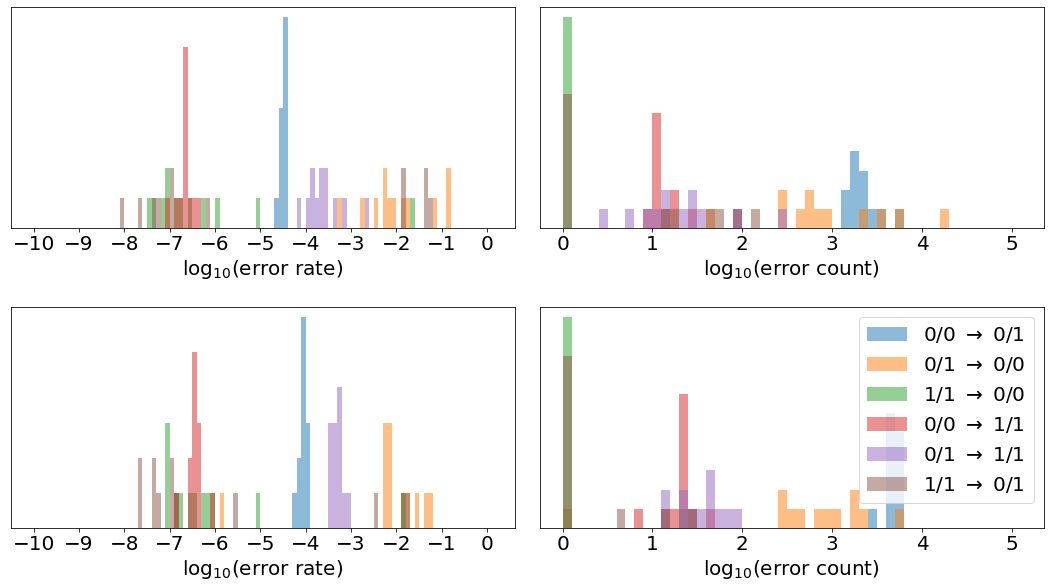

In [164]:
lcl_samples = sorted(set([x for x, y in zip(ihart_samples, ihart_is_child) if 'LCL' in x and y]))
wb_samples = sorted(set([x[:-4] for x in lcl_samples]))
is_lcl = [ihart_samples.index(x) for x in lcl_samples]
is_wb = [ihart_samples.index(x) for x in wb_samples]
print(is_lcl, is_wb)

plt.figure(figsize=(15, 12))

plt.subplot(3, 2, 1)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(-np.clip(ihart_error_rates[is_lcl, gens.index(g), obss.index(o)], 0, 10), 
             bins=np.arange(-10, 0.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)

    plt.xlabel('$\log_{10}$(error rate)')
    plt.yticks([], [])
    plt.xticks(np.arange(-10, 1))
    
plt.subplot(3, 2, 2)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(np.clip(np.log10(ihart_error_counts[is_lcl, gens.index(g), obss.index(o)]), 0, 5), 
             bins=np.arange(0, 5.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)

    plt.xlabel('$\log_{10}$(error count)')
    plt.yticks([], [])
    plt.xticks(np.arange(6))
    
plt.subplot(3, 2, 3)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(-np.clip(ihart_error_rates[is_wb, gens.index(g), obss.index(o)], 0, 10), 
             bins=np.arange(-10, 0.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)
    plt.xlabel('$\log_{10}$(error rate)')
    plt.yticks([], [])
    plt.xticks(np.arange(-10, 1))
    
plt.subplot(3, 2, 4)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(np.clip(np.log10(ihart_error_counts[is_wb, gens.index(g), obss.index(o)]), 0, 5), 
             bins=np.arange(0, 5.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)

    plt.xlabel('$\log_{10}$(error count)')
    plt.yticks([], [])
    plt.xticks(np.arange(6))


plt.legend()    
plt.tight_layout()
plt.show()



* 0/0 0/1 6.866657005127332e-08
 0/1 0/0 0.48169403642486097
 1/1 0/0 0.82603855822406
 0/0 1/1 0.008666562388306275
 0/1 1/1 0.04604523936386305
 1/1 0/1 0.31319939136542935
* 0/0 ./. 0.0005083821460638822
 0/1 ./. 0.20157358389868957
 1/1 ./. 0.044154324264661725


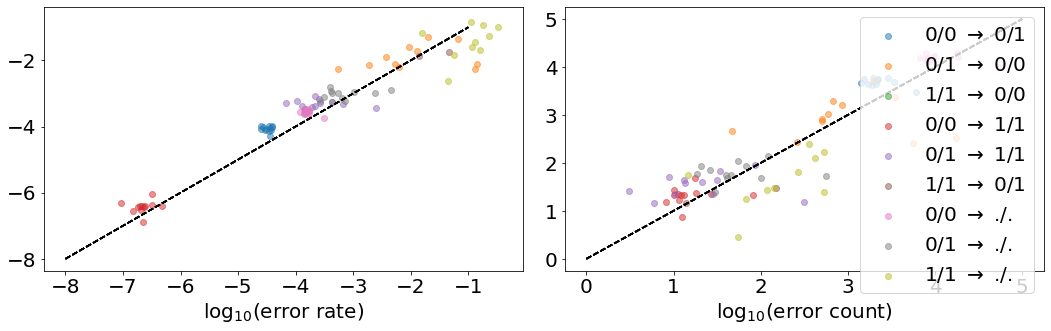

In [165]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            ('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    
    indices = (ihart_error_counts[is_lcl, gens.index(g), obss.index(o)] >= 1) & (ihart_error_counts[is_wb, gens.index(g), obss.index(o)] >= 1)
    plt.scatter(-np.clip(ihart_error_rates[is_lcl, gens.index(g), obss.index(o)][indices], 0, 8), 
                -np.clip(ihart_error_rates[is_wb, gens.index(g), obss.index(o)][indices], 0, 8),
                label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5)
    
    #print(g, o, scipy.stats.ttest_rel(10.0**-ihart_error_rates[is_lcl, gens.index(g), obss.index(o)],
    #                           10.0**-ihart_error_rates[is_wb, gens.index(g), obss.index(o)]))
    test = scipy.stats.ttest_rel(ihart_error_rates[is_lcl, gens.index(g), obss.index(o)],
                               ihart_error_rates[is_wb, gens.index(g), obss.index(o)])
    print('*' if test.pvalue*9 < 0.05 else '', g, o, test.pvalue)
    plt.xlabel('$\log_{10}$(error rate)')
    plt.xticks(np.arange(-8, 0))
    plt.plot(np.arange(-8, 0), np.arange(-8, 0), color='black', linestyle='--')


plt.subplot(1, 2, 2)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            ('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    indices = (ihart_error_counts[is_lcl, gens.index(g), obss.index(o)] >= 1) & (ihart_error_counts[is_wb, gens.index(g), obss.index(o)] >= 1)
    plt.scatter(np.clip(np.log10(ihart_error_counts[is_lcl, gens.index(g), obss.index(o)])[indices], 0, 5), 
                np.clip(np.log10(ihart_error_counts[is_wb, gens.index(g), obss.index(o)])[indices], 0, 5), 
             label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5)

    plt.xlabel('$\log_{10}$(error count)')
    plt.xticks(np.arange(6))
    plt.plot(np.arange(6), np.arange(6), color='black', linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()



* 0/0 0/1 6.866657005127332e-08
 0/1 0/0 0.48169403642486097
 1/1 0/0 0.82603855822406
 0/0 1/1 0.008666562388306275
 0/1 1/1 0.04604523936386305
 1/1 0/1 0.31319939136542935
* 0/0 ./. 0.0005083821460638822
 0/1 ./. 0.20157358389868957
 1/1 ./. 0.044154324264661725


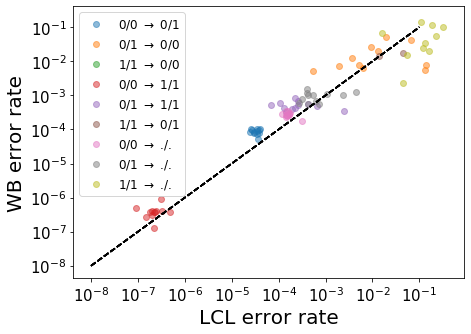

In [166]:
plt.figure(figsize=(7, 5))

for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            ('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    
    indices = (ihart_error_counts[is_lcl, gens.index(g), obss.index(o)] >= 1) & (ihart_error_counts[is_wb, gens.index(g), obss.index(o)] >= 1)
    plt.scatter(-np.clip(ihart_error_rates[is_lcl, gens.index(g), obss.index(o)][indices], 0, 8), 
                -np.clip(ihart_error_rates[is_wb, gens.index(g), obss.index(o)][indices], 0, 8),
                label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5)
    
    #print(g, o, scipy.stats.ttest_rel(10.0**-ihart_error_rates[is_lcl, gens.index(g), obss.index(o)],
    #                           10.0**-ihart_error_rates[is_wb, gens.index(g), obss.index(o)]))
    test = scipy.stats.ttest_rel(ihart_error_rates[is_lcl, gens.index(g), obss.index(o)],
                               ihart_error_rates[is_wb, gens.index(g), obss.index(o)])
    print('*' if test.pvalue*9 < 0.05 else '', g, o, test.pvalue)
    plt.xlabel('LCL error rate')
    plt.ylabel('WB error rate')
    plt.xticks(np.arange(-8, 0), [r'$10^{%d}$' % x for x in np.arange(-8, 0)], fontsize=15)
    plt.yticks(np.arange(-8, 0), [r'$10^{%d}$' % x for x in np.arange(-8, 0)], fontsize=15)
    plt.plot(np.arange(-8, 0), np.arange(-8, 0), color='black', linestyle='--')
    plt.legend(fontsize=12)
    
plt.show()

# Misc

In [45]:
# pull lcl/wb sample ids
lcl_samples = [ihart_samples[i] for i in is_lcl]
wb_samples = [ihart_samples[i] for i in is_wb]
print(lcl_samples, wb_samples)

samples_of_interest = []
with open('../data/170925.iHART.db.csv', 'r') as f:
    for line in f:
        pieces = line.strip().split(',')
        if pieces[2] in wb_samples or pieces[2] in lcl_samples:
            samples_of_interest.append(pieces[1])
print(samples_of_interest)

['AU1308303_LCL', 'AU1860301_LCL', 'AU2410302_LCL', 'AU2911309_LCL', 'AU3051303_LCL', 'AU3053301_LCL', 'AU3154301_LCL', 'AU3646301_LCL', 'AU3713302_LCL', 'AU3761302_LCL', 'AU3846302_LCL', 'AU4235303_LCL'] ['AU1308303', 'AU1860301', 'AU2410302', 'AU2911309', 'AU3051303', 'AU3053301', 'AU3154301', 'AU3646301', 'AU3713302', 'AU3761302', 'AU3846302', 'AU4235303']
['09C80191', '09C80191_LCL', '10C102326', '10C102326_LCL', '10C102516', '10C102516_LCL', '10C104029', '10C104029_LCL', '10C104575', '10C104575_LCL', '10C110450', '10C110450_LCL', '10C112859', '10C112859_LCL', '11C120729', '11C120729_LCL', '11C123778', '11C123778_LCL', 'MH0131365', 'MH0131365_LCL', 'MH0134528', 'MH0134528_LCL', 'MH0138042', 'MH0138042_LCL']
